In [ ]:
!pip install -q --force transformers==4.52.4
!pip install -U bitsandbytes
!pip install -q --force accelerate==1.7.0
!pip install -q --force langchain==0.3.25
!pip install -q --force langchainhub==0.1.21
!pip install -q --force langchain-chroma==0.2.4
!pip install -q --force langchain_experimental==0.3.4
!pip install -q --force langchain-community==0.3.24
!pip install -q --force langchain_huggingface==0.2.0
!pip install -q --force python-dotenv==1.1.0
!pip install -q --force pypdf
!pip install langchain_openai
!pip install langchain-google-genai
!pip install rank_bm25


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.3.4 which is incompatible.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.10.0 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.4 which is incompatible.
s3fs 2024.6.1 requires fsspec==2024.6.1.*, but you have fsspec 2025.10.0 which is incompatible.
scipy 1.13.1 requires numpy<2.3,>=1.22.4, but you have numpy 2.3.4 which is incompatible.
streamlit 1.37.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependenc

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
     ------------------ --------------------- 1.8/4.0 MB 12.6 MB/s eta 0:00:01
     ---------------------------------------- 4.0/4.0 MB 10.9 MB/s  0:00:00
     ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
     --------------- ------------------------ 1.6/4.0 MB 12.0 MB/s eta 0:00:01
     ---------------------------------------  3.9/4.0 MB 11.2 MB/s eta 0:00:01
     ---------------------------------------- 4.0/4.0 MB 10.9 MB/s  0:00:00
     ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
     ------- -------------------------------- 0.8/4.0 MB 6.7 MB/s eta 0:00:01
     ---------------------------- ----------- 2.9/4.0 MB 8.8 MB/s eta 0:00:01
     -------------------------------

  You can safely remove it manually.
  You can safely remove it manually.


In [ ]:
!pip install sentence-transformers==2.2.2 
!pip install accelerate


In [9]:
from dotenv import load_dotenv
import os

# Load environment variables from .env in project root
load_dotenv()

googleAPIKey = os.getenv('googleAPIKey')
gptkey =  os.getenv('myAPIKey')

In [4]:
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain_huggingface import HuggingFacePipeline
from langchain import hub

from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import OpenAIEmbeddings
import re

import torch
import json
import glob
import os

## Load file

In [5]:
metadata_dir = "C:\\uit_HK5\\CS431\\final_project\\data\\metadata.json"
transcript_dir = "C:\\uit_HK5\\CS431\\final_project\\data\\transcripts_final"
output_dir = "C:\\uit_HK5\\CS431\\final_project\\data\\semantic_chunks"
os.makedirs(output_dir, exist_ok=True)


In [6]:
from typing import Union

class Loader:
    @staticmethod
    def parse_transcript(file_path: str) -> tuple[str, list[dict], str]:
        """Đọc file transcript, tách từng dòng thành block có start-end-text"""
        full_text = ""
        position_map = []  # lưu vị trí start của mỗi đoạn text trong full_text

        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line or "[âm nhạc]" in line.lower():
                    continue
                filename = os.path.basename(file_path).replace(".txt", "") # lấy file name
                match = re.match(r"(\d+:\d+:\d+)\s*-\s*(\d+:\d+:\d+),\s*(.+)", line)
                if match:
                    start, end, text = match.groups()
                    pos = len(full_text)
                    full_text += text + " "
                    position_map.append({
                        "start": start,
                        "end": end,
                        "text": text,
                        "pos_start": pos, # vị trí bắt đầu của đoạn text trong full_text
                        "pos_end": len(full_text) # vị trí kết thúc của đoạn text trong full_text
                    })

        return full_text.strip(), position_map, filename
    
    def map_metadata(self, metadata_path: str, filename: str) -> tuple[Union[str, None], Union[str, None]]:
        """Đọc file metadata và trả về dict mapping id -> metadata"""

        with open(metadata_path, "r", encoding="utf-8") as f:
            metadata_list = json.load(f)
        metadata = metadata_list["videos"]

        video_title, video_url = next(((item["title"], item["url"]) for item in metadata if item["video_id"] == filename), (None, None))

        return video_title, video_url
    
    def load_dir(self, transcript_dir: str, metadata_path: str) -> list[dict]:
        """Đọc tất cả file transcript trong thư mục và trả về danh sách dict chứa full_text, position_map, filename, title, url"""
        import glob

        file_paths = glob.glob(os.path.join(transcript_dir, "*.txt"))
        data = []

        for file_path in file_paths:
            full_text, position_map, filename = self.parse_transcript(file_path)
            title, url = self.map_metadata(metadata_path, filename)

            data.append({
                "full_text": full_text,
                "position_map": position_map,
                "filename": filename,
                "title": title,
                "url": url
            })

        return data
        

## Chunking

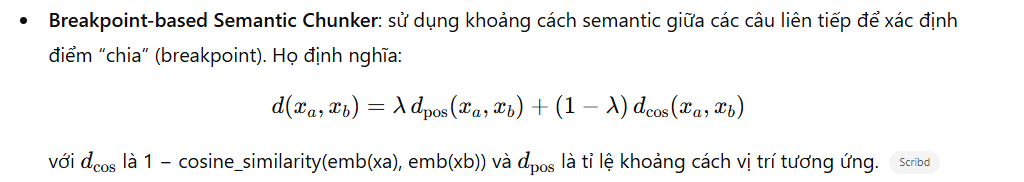

In [10]:

from pyparsing import line


class TranscriptChunker:
    def __init__(self, open_api_key: str):
        self.embeddings = OpenAIEmbeddings(
            model="text-embedding-3-large",
            openai_api_key=open_api_key
        )
        self.splitter = SemanticChunker(
            embeddings=self.embeddings,
            breakpoint_threshold_type="percentile",
            breakpoint_threshold_amount=85,
            min_chunk_size=300,

            add_start_index=True,
            buffer_size=1
        )
        self.loader = Loader()

    def chunk_dir(self, transcript_dir: str, metadata_path: str, output_dir: str) -> list:
        data = self.loader.load_dir(transcript_dir, metadata_path)
        all_chunks = []

        for item in data:
            full_text = item["full_text"]
            position_map = item["position_map"]
            filename = item["filename"]
            title = item["title"]
            url = item["url"]

            # dùng lại logic mapping timestamp
            chunks = self.splitter.create_documents(
                texts=[full_text],
                metadatas=[{
                    "video_url": url,
                    "filename": filename,
                    "title": title
                }]
            )
            for i, chunk in enumerate(chunks):
                start_index = chunk.metadata.pop("start_index")
                end_index = start_index + len(chunk.page_content)  # tự tính end_index

                
                # tìm timestamp đầu tiên bao phủ đoạn text này
                matched_ts = [
                    pos for pos in position_map
                    if not (pos["pos_end"] < start_index or pos["pos_start"] > end_index)
                ]

                if matched_ts:
                    chunk.metadata["start_timestamp"] = matched_ts[0]["start"]
                    chunk.metadata["end_timestamp"] = matched_ts[-1]["end"]
                else:
                    chunk.metadata["start_timestamp"] = None
                    chunk.metadata["end_timestamp"] = None

                chunk.metadata["chunk_id"] = i
            all_chunks.extend(chunks)
        # lưu tất cả chunks vào file json
        output_path = os.path.join(output_dir, "semantic_chunks.json")
        with open(output_path, "w", encoding="utf-8") as f:
            json.dump([{
                "page_content": chunk.page_content,
                "metadata": chunk.metadata
            } for chunk in all_chunks], f, ensure_ascii=False, indent=4)
        print(f"Saved {len(all_chunks)} chunks to {output_path}")
        return all_chunks


In [11]:
splitter = TranscriptChunker(
    open_api_key= gptkey
)
data = splitter.chunk_dir(transcript_dir, metadata_dir, output_dir)

Saved 461 chunks to C:\uit_HK5\CS431\final_project\data\semantic_chunks\semantic_chunks.json


In [12]:
#test print first 3 chunks
for chunk in data[:3]:
    print(chunk.page_content)
    print(chunk.metadata["start_timestamp"], chunk.metadata["end_timestamp"])
    print(chunk.metadata["video_url"])
    print(chunk.metadata["title"])
    print("-----")

Như vậy thì trong phần số 2 này thì chúng ta đã cùng tìm hiểu về những chủ đề sau. Đầu tiên là chúng ta tìm hiểu về maximum likelihood cho cái log của PX. Chúng ta mong muốn có được một mô hình để tạo ra một cái ảnh x giống thật, giống với lại cái Pdata. Thế thì để đạt được cái việc này thì cái likelihood của log P này phải là lớn nhất. Và khi đưa cái log của PX này lên cực đại thì nó sẽ đưa đến một cái giải pháp, đó là chúng ta sẽ đẩy cái chặn dưới của log P. Thì đó chính là cái ELBO là evidence lower bound.
0:00:14 0:01:06
https://youtube.com/watch?v=--6FInuIyys
[CS315 - Chương 3] Deep Generative Models (2) - Tổng kết
-----
Đẩy cái ELBO này lên, maximum ELBO này lên. Và khi chúng ta maximum ELBO này lên thì chúng ta sẽ có hai cái mô hình, đó là VAE và mô hình diffusion. Và đối với cái mô hình diffusion thì chúng ta sẽ có cái bước gọi là khuếch tán thuận. Và trong cái khuếch tán thuận này thì chúng ta sẽ thêm nhiễu vào cái ảnh của mình. Và ở đây là chúng ta không có tham số để học, kh

In [ ]:
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

model_name = "BAAI/bge-m3"            # đa ngôn ngữ, gọn nhẹ, khuyên dùng

embedding = HuggingFaceEmbeddings(model_name=model_name,model_kwargs={"device": "cuda"})

## lưu vào db

vector_db = Chroma.from_documents(documents=data , embedding= embedding, persist_directory="../database")
retriever = vector_db.as_retriever(search_type="similarity", search_kwargs={"k": 10})

KeyboardInterrupt: 

In [17]:
result = retriever.invoke("diffusion là gì")

print(result[0].page_content)

Chúng ta sẽ cùng đến với các mô hình tạo sinh học sau Deep Generated Model phần 2, mô hình Diffusion. Các mô hình tạo sinh hình ảnh đều có gốc gác sử dụng mô hình phát tán, mô hình Diffusion Model. Đây có thể nói là một trong những mô hình có tính ứng dụng rất cao do tạo ra những ảnh có độ phân giải cao, đồng thời có thể cho chúng ta can thiệp và điều hướng nội dung của tấm ảnh. Vậy thì ý tưởng của Diffusion là gì và cách thức huấn luyện ra sao, chúng ta sẽ cùng tìm hiểu trong bài ngày hôm nay. Các vấn đề chính khi chúng ta tìm hiểu một mô hình Diffusion Model, mô hình phát tán, đó là chúng ta sẽ tìm hiểu về mô hình tạo sinh tổng quát. Mô hình tạo sinh tổng quát này sẽ dựa trên lý thuyết về xác suất thống kê.


In [16]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import numpy as np

# 🔹 Lấy toàn bộ embedding và metadata từ Chroma
# (nếu bạn đã load vector_db = Chroma.from_documents(...) như trên)
data = vector_db.get()  

vectors = vector_db.get(include=["embeddings"])
vectors = np.array(vectors["embeddings"])
documents = data["documents"]
metadatas = data["metadatas"]

# 🔹 Nếu bạn có nhiều loại document, có thể trích ra từ metadata
doc_types = [m.get("title", "unknown") for m in metadatas]
colors = ["blue" if t == "unknown" else "red" for t in doc_types]

# 🔹 Giảm số chiều xuống 2D để trực quan hóa
tsne = TSNE(n_components=2, random_state=42, perplexity=1)
reduced_vectors = tsne.fit_transform(vectors)

# 🔹 Vẽ biểu đồ scatter 2D
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=6, color=colors, opacity=0.8),
    text=[
        f"<b>Loại:</b> {t}<br><b>Văn bản:</b> {d[:200]}..." 
        for t, d in zip(doc_types, documents)
    ],
    hoverinfo='text'
)])

fig.update_layout(
    title='📊 Phân bố embedding trong Chroma Vector Store (2D)',
    xaxis_title='TSNE Dimension 1',
    yaxis_title='TSNE Dimension 2',
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40),
)

# 🔹 Hiển thị trực tiếp trên browser
fig.show(renderer="browser")


## Reranking by BM25 + create hybrid search with semantic search + bm25

## Load db + vector retriever


In [18]:
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

model_name = "BAAI/bge-m3"            # đa ngôn ngữ, gọn nhẹ, khuyên dùng

embedding = HuggingFaceEmbeddings(model_name=model_name,model_kwargs={"device": "cuda"})

## lưu vào db
vector_db = Chroma( embedding_function= embedding, persist_directory="../database")
vector_retriever = vector_db.as_retriever(search_type="mmr", search_kwargs={"k": 20})

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_28524\3277164955.py:9: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_db = Chroma( embedding_function= embedding, persist_directory="../database")


## bm25

In [ ]:
from rank_bm25 import BM25Okapi
from langchain.schema import Document
from langchain_core.runnables import RunnableLambda
from langchain.retrievers import EnsembleRetriever

# ===== 1. Lấy doc từ Chroma =====
raw = vector_db.get(include=["documents", "metadatas"])
docs = []
for content, metadata in zip(raw["documents"], raw["metadatas"]):
    docs.append(Document(
        page_content=content,
        metadata={
            "filename": metadata.get("filename", ""),
            "video_url": metadata.get("video_url", ""),
            "start_timestamp": metadata.get("start_timestamp", "")
        }
    ))

# ===== 2. BM25 retriever an toàn =====
if docs:
    corpus_tokens = [doc.page_content.split() for doc in docs]
    bm25_model = BM25Okapi(corpus_tokens)

    def bm25_retriever(query, top_k=5):
        tokenized_query = query.split()
        scores = bm25_model.get_scores(tokenized_query)
        top_k = min(top_k, len(docs))  # bảo vệ out-of-range
        top_indices = scores.argsort()[-top_k:][::-1]
        return [docs[i] for i in top_indices]

    class BM25Retriever:
        def __init__(self, top_k=30):
            self.top_k = top_k

        def get_relevant_documents(self, query: str):
            return bm25_retriever(query, top_k=self.top_k)

    keyword_retriever = BM25Retriever(top_k=30)
    bm25_runnable = RunnableLambda(lambda x: keyword_retriever.get_relevant_documents(x))
else:
    # fallback nếu không có docs
    bm25_runnable = RunnableLambda(lambda x: [])



# ===== 4. Hybrid retriever =====
hybrid_retriever = EnsembleRetriever(
    retrievers=[bm25_runnable, vector_retriever],
    weights=[0.5, 0.5]
)


## generate text

### Chọn mô hình (qwen 0.6b hoặc api gemini)

In [89]:


nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True
)

MODEL_NAME = "Qwen/Qwen3-0.6B"


model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    dtype=torch.float16,   # dùng float16 cho GPU
    #device_map="auto"      # tự động đặt model lên GPU
)
model.to("cuda")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True,trust_remote_code=True)



In [90]:
model_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id,
    device=0  # chạy trên CPU

)

llm = HuggingFacePipeline(pipeline=model_pipeline)


Device set to use cuda:0


## gemini 

In [19]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",   # hoặc gemini-1.5-pro, gemini-2.0-flash
    temperature=0.0,
    google_api_key=googleAPIKey  # 👈 thêm dòng này
)

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableMap,RunnableLambda


class VideoAnswer(BaseModel):
    text: str = Field(description="Câu trả lời tóm tắt trong 3 câu")
    filename: str = Field(description="Tên file transcript gốc")
    video_url: str = Field(description="URL của video gốc")
    start_timestamp: str = Field(description="Thời điểm bắt đầu (format: HH:MM:SS)")
    end_timestamp: str = Field(description="Thời điểm kết thúc (format: HH:MM:SS)")
    confidence: str = Field(description="Độ tin cậy: zero/low/medium/high")

parser = JsonOutputParser(pydantic_object=VideoAnswer)

# ===== Prompt =====
prompt = ChatPromptTemplate.from_template("""
Dựa vào transcript sau, trả lời câu hỏi của người dùng bằng tiếng Việt.Phần tóm tắt nội dung thì nên tóm tắt trong 3 câu, 
dựa vào các đoạn transcript được cung cấp và chỉ ra đoạn video chứa thông tin đó (video url, thời điểm bắt đầu và kết thúc).
Đồng thời làm mượt lại nội dung tóm tắt đó
Khi trích dẫn thông tin, **luôn sử dụng đúng [Video URL] và [Start] từ doc chứa nội dung đó**.
Nếu không biết câu trả lời thì cứ trả lời là tôi không biết và độ tin cậy là zero
Nếu câu hỏi không liên quan đến nội dung video thì trả lời tôi chỉ được huấn luyện trả lời các câu hỏi liên quan đến nội dung video và độ tin cậy là zero
Không bịa ra thông tin không có căn cứ, không trả lời sai format
Nếu bạn cực kỳ chắc chắn về câu trả lời, hãy đặt độ tin cậy là high. Nếu bạn khá chắc chắn, hãy đặt độ tin cậy là medium. Nếu bạn không chắc chắn về câu trả lời, hãy đặt độ tin cậy là low.
Định dạng đầu ra phải tuân theo JSON schema sau:
{format_instructions}
Transcript:
{context}

Câu hỏi: {question}
\nAnswer:                                          
""")

def format_doc(docs):
    formatted = []
    for doc in docs:
        url = doc.metadata.get("video_url", "")
        filename = doc.metadata.get("filename", "")
        start = doc.metadata.get("start_timestamp", "")
        end = doc.metadata.get("end_timestamp", "")
        content = doc.page_content
        formatted.append(f"""[Video URL]: {url}
[Filename]: {filename}
[Start]: {start}
[End]: {end}
[Content]: {content}""")
    return "\n\n".join(formatted)
def extract_json_from_output(output: str) -> str:
    return output.split('Answer')[1].strip()
    
# ===== Tạo RAG chain =====
rag_chain = (
    {
        "context": retriever| format_doc,  # format từng doc
        "question": RunnablePassthrough()
    }
    | prompt.partial(format_instructions=parser.get_format_instructions())
    | llm 
    #| #extract_json_from_output # lấy phần đằng sau answer ( là định dạng json đã chuẩn bị)
    #RunnableLambda(lambda x: extract_json_from_output(x))
    #|parser
)

C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3550: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
import time
start = time.time()
result = rag_chain.invoke("Tại sao việc tự huấn luyện mô hình CLIP từ đầu là khó khả thi?")
print(result.content)
end = time.time()
print("Thời gian:", end - start)


```json
{
  "text": "Việc tự huấn luyện mô hình CLIP từ đầu là không khả thi vì nó đòi hỏi một lượng dữ liệu cực kỳ lớn. Ngoài ra, quá trình này còn yêu cầu tài nguyên tính toán khổng lồ, khả năng xử lý song song và các thiết bị GPU rất đắt tiền. Do đó, giải pháp khả thi nhất là sử dụng các mô hình CLIP đã được tiền huấn luyện để giải quyết các tác vụ hiện có.",
  "filename": "yPzXzbEhUW0",
  "video_url": "https://youtube.com/watch?v=yPzXzbEhUW0",
  "start_timestamp": "00:00:14",
  "end_timestamp": "00:01:03",
  "confidence": "high",
  "Reference": "[Video URL]: https://youtube.com/watch?v=yPzXzbEhUW0 [Start]: 0:00:14 [End]: 0:01:03 [Content]: Chúng ta sẽ cùng tìm hiểu về cách sử dụng một cái mô hình clip đã được tiền huấn luyện trên một bộ dữ liệu vô cùng lớn của OpenAI. Vì vậy, tự huấn luyện được môn clip là khá là không khả thi, vì nó cần lượng data cực kỳ lớn, tài nguyên tính toán, xử lý song song, GPU cũng cực kỳ mắc tiền. Vì vậy, khả duy nhất của chúng ta lúc này là chúng ta sẽ s